# HTR-10 Pebble-Bed Reactor — Calcul de k_eff avec OpenMC

Modèle simplifié basé sur le benchmark **HTR10-GCR-RESR-001** (Terry et al., INL, 2006).

**Configuration critique initiale** (1 décembre 2000) :
- 16 890 billes (9 627 combustible + 7 263 graphite)
- Hauteur du cœur : 123,06 cm
- Diamètre du cœur : 180 cm
- Fraction volumique des billes : 0,61
- Coolant : air humide saturé à 15 °C, 0,1013 MPa
- k_eff attendu (MCNP, modèle simplifié) : 1,025 ± 0,00021

**Structure du notebook** :
1. Matériaux
2. Géométrie simplifiée (cœur homogénéisé + réflecteur)
3. Tallies
4. Settings & lancement

In [1]:
%matplotlib inline
import openmc
import numpy as np
print('OpenMC version:', openmc.__version__)

OpenMC version: 0.15.3


---
## 1. MATÉRIAUX

Toutes les densités atomiques sont issues des **Tables 3.6, 3.7 et 3.8** du rapport benchmark.

### 1.1 Particules TRISO — noyau UO₂

In [2]:
# =============================================================
#  NOYAU UO2  (Table 3.7)
#  Densité : 10.4 g/cm3
#  Enrichissement : 17 % en masse (235U)
#  Boron dans le noyau : 4 ppm
#  Densités atomiques (atoms/barn-cm) :
#    235U : 3.99198E-3   238U : 1.92441E-2   O16 : 4.64720E-2
#    10B  : 4.06384E-7   11B  : 1.63575E-6
# =============================================================

kernel = openmc.Material(name='UO2_Kernel')
kernel.add_nuclide('U235',  3.99198e-3, 'ao')
kernel.add_nuclide('U238',  1.92441e-2, 'ao')
kernel.add_nuclide('O16',   4.64720e-2, 'ao')
kernel.add_nuclide('B10',   4.06384e-7, 'ao')
kernel.add_nuclide('B11',   1.63575e-6, 'ao')
kernel.set_density('g/cm3', 10.4)

### 1.2 Couches de revêtement TRISO

In [3]:
# =============================================================
#  COUCHE BUFFER — Carbone poreux  (Table 3.7)
#  Densité : 1.1 g/cm3 — Bore : 1.3 ppm
#  C : 5.51511E-2   10B : 1.58513E-8   11B : 6.38035E-8
# =============================================================
buffer = openmc.Material(name='Buffer_C')
buffer.add_nuclide('C0',   5.51511e-2, 'ao')
buffer.add_nuclide('B10',  1.58513e-8, 'ao')
buffer.add_nuclide('B11',  6.38035e-8, 'ao')
buffer.set_density('g/cm3', 1.1)
buffer.add_s_alpha_beta('c_Graphite')

# =============================================================
#  IPyC (Inner Pyrolytic Carbon)  (Table 3.7)
#  Densité : 1.9 g/cm3 — Bore : 1.3 ppm
#  C : 9.52610E-2   10B : 2.73795E-8   11B : 1.10206E-7
# =============================================================
IPyC = openmc.Material(name='IPyC')
IPyC.add_nuclide('C0',   9.52610e-2, 'ao')
IPyC.add_nuclide('B10',  2.73795e-8, 'ao')
IPyC.add_nuclide('B11',  1.10206e-7, 'ao')
IPyC.set_density('g/cm3', 1.9)
IPyC.add_s_alpha_beta('c_Graphite')

# =============================================================
#  SiC  (Table 3.7)
#  Densité : 3.18 g/cm3 — pas de bore
#  C : 4.77597E-2   Si(nat) : 4.77597E-2
# =============================================================
SiC = openmc.Material(name='SiC')
SiC.add_nuclide('C0',    4.77597e-2, 'ao')
SiC.add_element('Si',    4.77597e-2, 'ao')
SiC.set_density('g/cm3', 3.18)

# =============================================================
#  OPyC (Outer Pyrolytic Carbon)  (Table 3.7)
#  Identique à IPyC (même densité et composition)
# =============================================================
OPyC = openmc.Material(name='OPyC')
OPyC.add_nuclide('C0',   9.52610e-2, 'ao')
OPyC.add_nuclide('B10',  2.73795e-8, 'ao')
OPyC.add_nuclide('B11',  1.10206e-7, 'ao')
OPyC.set_density('g/cm3', 1.9)
OPyC.add_s_alpha_beta('c_Graphite')

### 1.3 Matrice graphite des billes combustible et dummy

In [4]:
# =============================================================
#  MATRICE GRAPHITE — bille combustible  (Table 3.7)
#  Densité : 1.73 g/cm3 — Bore : 1.3 ppm
#  C : 8.67377E-2   10B : 2.49298E-8   11B : 1.00345E-7
# =============================================================
fuel_matrix = openmc.Material(name='Fuel_Matrix_Graphite')
fuel_matrix.add_nuclide('C0',   8.67377e-2, 'ao')
fuel_matrix.add_nuclide('B10',  2.49298e-8, 'ao')
fuel_matrix.add_nuclide('B11',  1.00345e-7, 'ao')
fuel_matrix.set_density('g/cm3', 1.73)
fuel_matrix.add_s_alpha_beta('c_Graphite')

# =============================================================
#  BILLE DUMMY (graphite pur)  (Table 3.7)
#  Densité : 1.84 g/cm3 — Bore : 0.125 ppm (as-built)
#  C : 9.22528E-2   10B : 2.54951E-9   11B : 1.02621E-8
# =============================================================
dummy_graphite = openmc.Material(name='Dummy_Pebble_Graphite')
dummy_graphite.add_nuclide('C0',   9.22528e-2, 'ao')
dummy_graphite.add_nuclide('B10',  2.54951e-9, 'ao')
dummy_graphite.add_nuclide('B11',  1.02621e-8, 'ao')
dummy_graphite.set_density('g/cm3', 1.84)
dummy_graphite.add_s_alpha_beta('c_Graphite')

### 1.4 Réflecteur graphite et briques boronées

In [5]:
# =============================================================
#  GRAPHITE RÉFLECTEUR  (Table 3.6)
#  Densité : 1.76 g/cm3 — Bore naturel : 4.8366 ppm
#  C   : 8.82418E-2
#  10B : 9.42800E-8   11B : 3.79489E-7
# =============================================================
reflector_graphite = openmc.Material(name='Reflector_Graphite')
reflector_graphite.add_nuclide('C0',   8.82418e-2, 'ao')
reflector_graphite.add_nuclide('B10',  9.42800e-8, 'ao')
reflector_graphite.add_nuclide('B11',  3.79489e-7, 'ao')
reflector_graphite.set_density('g/cm3', 1.76)
reflector_graphite.add_s_alpha_beta('c_Graphite')

# =============================================================
#  BRIQUES CARBONE BORONÉES — périphérie réflecteur (Table 3.6)
#  Densité totale : 1.59 g/cm3, 5% B4C en masse
#  C   : 7.65984E-2
#  10B : 6.89235E-4   11B : 2.77426E-3
# =============================================================
boronated_bricks = openmc.Material(name='Boronated_Carbon_Bricks')
boronated_bricks.add_nuclide('C0',   7.65984e-2, 'ao')
boronated_bricks.add_nuclide('B10',  6.89235e-4, 'ao')
boronated_bricks.add_nuclide('B11',  2.77426e-3, 'ao')
boronated_bricks.set_density('g/cm3', 1.59)
boronated_bricks.add_s_alpha_beta('c_Graphite')

### 1.5 Coolant — Air humide saturé à 15 °C, 0.1013 MPa

In [6]:
# =============================================================
#  AIR HUMIDE SATURÉ (Table 3.8)
#  T = 15°C (288.15 K), P = 0.1013 MPa
#  Composition : 78.084% N2, 20.9476% O2, 0.934% Ar + vapeur d'eau
#
#  Densités atomiques (atoms/barn-cm) :
#    N  (air sec)   : 3.95901E-5  → N14
#    O  (air sec)   : 1.06209E-5  → O16
#    Ar             : 2.36778E-7  → Ar40
#    H  (vapeur)    : 8.58028E-7  → H1
#    O  (vapeur)    : 4.29014E-7  → O16
#  Total O16 = 1.06209E-5 + 4.29014E-7 = 1.10499E-5
# =============================================================
moist_air = openmc.Material(name='Moist_Air_15C')
moist_air.add_nuclide('N14',  3.95901e-5, 'ao')
moist_air.add_nuclide('O16',  1.10499e-5, 'ao')   # air sec + vapeur
moist_air.add_nuclide('Ar40', 2.36778e-7, 'ao')
moist_air.add_nuclide('H1',   8.58028e-7, 'ao')   # vapeur d'eau
moist_air.set_density('g/cm3', 1.205e-3)            # ~air à 15°C, 1 atm

### 1.6 Cœur homogénéisé (modèle simplifié)

Le cœur homogénéisé correspond à la **Table 4.2** du rapport — mélange pondéré :
- 57% bille combustible + 43% bille dummy + fraction vide (coolant)
- Packing fraction = 0.61 → fraction vide = 0.39

In [7]:
# =============================================================
#  CŒUR HOMOGÉNÉISÉ (Table 4.2)
#  Densités atomiques moyennes dans le cœur (atoms/barn-cm)
#
#  235U : 6.69520E-6   238U : 3.22755E-5
#  O16  (noyaux) : 7.79414E-5
#  Si   (nat)    : 8.51054E-5
#  C    (graphite): 5.40964E-2
#  10B  : 9.91914E-9   11B  : 3.99258E-8
#  Air humide (coolant, fraction vide = 39%) :
#    N14  : 1.52478E-5   O16(air) : 4.09052E-6
#    Ar40 : 9.11929E-8   H1       : 3.34631E-7
#    O16(eau): 1.67316E-7
#
#  Total O16 dans le cœur = O_noyaux + O_air + O_eau
#                         = 7.79414E-5 + 4.09052E-6 + 1.67316E-7
#                         = 8.37048E-5
# =============================================================

core_mix = openmc.Material(name='Core_Homogenized')
core_mix.add_nuclide('U235',  6.69520e-6,  'ao')
core_mix.add_nuclide('U238',  3.22755e-5,  'ao')
core_mix.add_nuclide('O16',   8.37048e-5,  'ao')   # total O16
core_mix.add_element('Si',    8.51054e-5,  'ao')   # Si naturel SiC
core_mix.add_nuclide('C0',    5.40964e-2,  'ao')
core_mix.add_nuclide('B10',   9.91914e-9,  'ao')
core_mix.add_nuclide('B11',   3.99258e-8,  'ao')
core_mix.add_nuclide('N14',   1.52478e-5,  'ao')   # air
core_mix.add_nuclide('Ar40',  9.11929e-8,  'ao')   # air
core_mix.add_nuclide('H1',    3.34631e-7,  'ao')   # vapeur
core_mix.set_density('sum')
core_mix.add_s_alpha_beta('c_Graphite')

print('Matériaux définis :', [m.name for m in
      [kernel, buffer, IPyC, SiC, OPyC, fuel_matrix, dummy_graphite,
       reflector_graphite, boronated_bricks, moist_air, core_mix]])

Matériaux définis : ['UO2_Kernel', 'Buffer_C', 'IPyC', 'SiC', 'OPyC', 'Fuel_Matrix_Graphite', 'Dummy_Pebble_Graphite', 'Reflector_Graphite', 'Boronated_Carbon_Bricks', 'Moist_Air_15C', 'Core_Homogenized']


### 1.7 Export des matériaux

In [8]:
# Matériaux utilisés dans le modèle simplifié
materials = openmc.Materials([
    core_mix,
    reflector_graphite,
    boronated_bricks,
    moist_air
])
materials.export_to_xml()
print('materials.xml exporté.')

materials.xml exporté.


---
## 2. GÉOMÉTRIE SIMPLIFIÉE

Modèle **r-z axisymétrique** (simplifié) selon la **Figure 3.5** du rapport :

| Zone | r (cm) | z (cm) | Description |
|------|--------|--------|-------------|
| Cœur cylindrique | 0–90 | 228.758–351.818 | Mélange billes combustible+dummy |
| Cavité core supérieure | 0–90 | 130–228.758 | Air |
| Réflecteur latéral | 90–167.793 | 0–610 | Graphite 1.76 g/cm³ |
| Réflecteur supérieur | 0–90 | 0–130 | Graphite |
| Réflecteur inférieur | 0–90 | 351.818–610 | Graphite |
| Briques boronées | 167.793–190 | 0–610 | Carbone boroné |

> Axes : z=0 en haut du réflecteur (convention du rapport)

In [9]:
# =============================================================
#  SURFACES
#  Convention : z=0 au sommet du réflecteur, z positif vers le bas
#  (Table 1.3, Figures 3.3/3.5)
# =============================================================

# --- Surfaces radiales ---
r_core        = openmc.ZCylinder(r=90.0,    name='r_core_inner')
r_refl_inner  = openmc.ZCylinder(r=90.0,    name='r_refl_inner')   # idem r_core
r_refl_outer  = openmc.ZCylinder(r=167.793, name='r_refl_outer')
r_boron_outer = openmc.ZCylinder(r=190.0,   name='r_boron_outer', boundary_type='vacuum')

# --- Surfaces axiales (z positif vers le bas, z=0 en haut) ---
z_top         = openmc.ZPlane(z0=0.0,   name='z_top',    boundary_type='vacuum')
z_top_refl    = openmc.ZPlane(z0=40.0,  name='z_top_refl')      # haut du graphite reflecteur
z_top_core    = openmc.ZPlane(z0=130.0, name='z_top_core')      # sommet de la cavité cœur
z_core_top_eq = openmc.ZPlane(z0=228.758, name='z_equiv_surface') # surface équivalente cœur
z_core_bot    = openmc.ZPlane(z0=351.818, name='z_core_bottom')  # fond cœur / haut conus
z_conus_bot   = openmc.ZPlane(z0=388.764, name='z_conus_bottom') # bas du conus
z_bot_refl    = openmc.ZPlane(z0=610.0, name='z_bottom',  boundary_type='vacuum')

print('Surfaces définies.')

Surfaces définies.


In [10]:
# =============================================================
#  RÉGIONS
# =============================================================

# ---- Cœur : mélange billes combustible + dummy ----
# z : 228.758 → 351.818, r : 0 → 90
core_region = (
    -r_core &
    +z_core_top_eq &
    -z_core_bot
)

# ---- Conus : billes dummy uniquement ----
# z : 351.818 → 388.764, r : 0 → 90
conus_region = (
    -r_core &
    +z_core_bot &
    -z_conus_bot
)

# ---- Cavité supérieure du cœur (air) ----
# z : 130 → 228.758, r : 0 → 90
top_cavity_region = (
    -r_core &
    +z_top_core &
    -z_core_top_eq
)

# ---- Réflecteur supérieur (graphite) ----
# z : 40 → 130, r : 0 → 90 + latéral 90 → 167.793
top_refl_axial = (
    -r_core &
    +z_top_refl &
    -z_top_core
)

# Tout le graphite du réflecteur supérieur (r : 0 → 167.793, z : 0 → 40)
top_refl_full = (
    -r_refl_outer &
    +z_top &
    -z_top_refl
)

# ---- Réflecteur latéral (graphite) ----
# z : 40 → 610, r : 90 → 167.793
side_refl_region = (
    +r_core &
    -r_refl_outer &
    +z_top_refl &
    -z_bot_refl
)

# ---- Réflecteur inférieur (graphite) ----
# z : 388.764 → 610, r : 0 → 90
bot_refl_region = (
    -r_core &
    +z_conus_bot &
    -z_bot_refl
)

# ---- Briques boronées (périphérie) ----
# z : 0 → 610, r : 167.793 → 190
boron_bricks_region = (
    +r_refl_outer &
    -r_boron_outer &
    +z_top &
    -z_bot_refl
)

print('Régions définies.')

Régions définies.


In [11]:
# =============================================================
#  CELLULES
# =============================================================

# Cœur actif
cell_core = openmc.Cell(name='Core_Active', fill=core_mix, region=core_region)

# Conus (billes dummy — on utilise dummy_graphite homogénéisé)
# Densité atomique dummy (Table 3.9 zone 6/7) : 5.72501E-2 at/b-cm en C
# On réutilise core_mix pour simplifier (conus dummy + air)
# Note : pour un calcul précis, créer dummy_homog séparé
dummy_conus = openmc.Material(name='Dummy_Conus_Homog')
dummy_conus.add_nuclide('C0',   5.72501e-2, 'ao')
dummy_conus.add_nuclide('B10',  2.77884e-9, 'ao')
dummy_conus.add_nuclide('B11',  1.11794e-8, 'ao')
# fraction vide 39% → air
dummy_conus.add_nuclide('N14',  1.52478e-5, 'ao')
dummy_conus.add_nuclide('O16',  4.09052e-6, 'ao')
dummy_conus.add_nuclide('Ar40', 9.11929e-8, 'ao')
dummy_conus.add_nuclide('H1',   3.34631e-7, 'ao')
dummy_conus.set_density('sum')
dummy_conus.add_s_alpha_beta('c_Graphite')
materials.append(dummy_conus)

cell_conus   = openmc.Cell(name='Conus_Dummy',       fill=dummy_conus,        region=conus_region)
cell_topcav  = openmc.Cell(name='Top_Core_Cavity',   fill=moist_air,          region=top_cavity_region)
cell_toprefl1= openmc.Cell(name='Top_Reflector_Axial', fill=reflector_graphite, region=top_refl_axial)
cell_toprefl2= openmc.Cell(name='Top_Reflector_Full',  fill=reflector_graphite, region=top_refl_full)
cell_siderefl= openmc.Cell(name='Side_Reflector',    fill=reflector_graphite, region=side_refl_region)
cell_botrefl = openmc.Cell(name='Bottom_Reflector',  fill=reflector_graphite, region=bot_refl_region)
cell_boron   = openmc.Cell(name='Boronated_Bricks',  fill=boronated_bricks,  region=boron_bricks_region)

all_cells = [
    cell_core, cell_conus, cell_topcav,
    cell_toprefl1, cell_toprefl2,
    cell_siderefl, cell_botrefl,
    cell_boron
]
print('Cellules créées :', [c.name for c in all_cells])

Cellules créées : ['Core_Active', 'Conus_Dummy', 'Top_Core_Cavity', 'Top_Reflector_Axial', 'Top_Reflector_Full', 'Side_Reflector', 'Bottom_Reflector', 'Boronated_Bricks']


In [12]:
# =============================================================
#  UNIVERS & GÉOMÉTRIE
# =============================================================

universe = openmc.Universe(cells=all_cells)
geometry = openmc.Geometry(universe)

# Màj materials avec dummy_conus
materials = openmc.Materials([
    core_mix, dummy_conus, reflector_graphite,
    boronated_bricks, moist_air
])
materials.export_to_xml()
geometry.export_to_xml()
print('geometry.xml et materials.xml exportés.')

geometry.xml et materials.xml exportés.


### 2.1 Visualisation de la géométrie

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

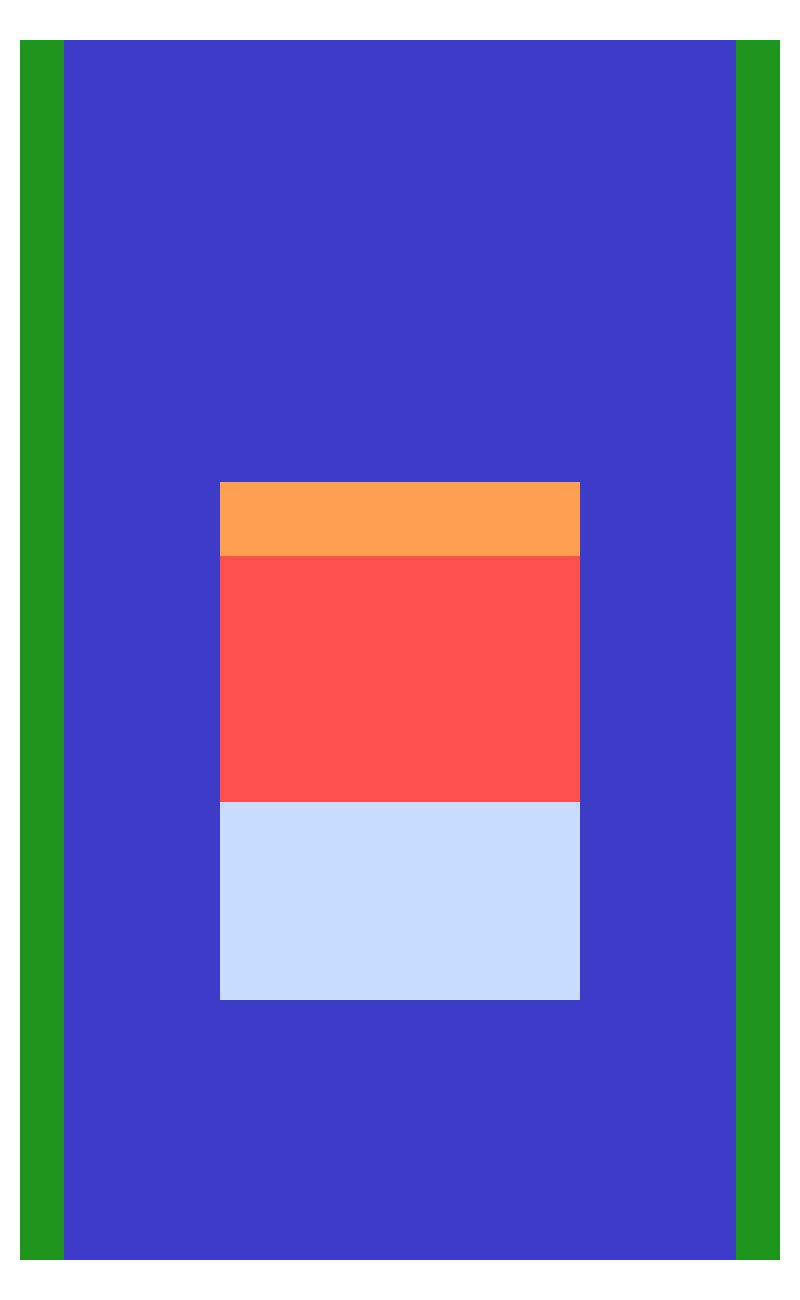

In [13]:
# Vue r-z (coupe XZ)
colors = {
    core_mix          : (255, 80, 80),      # rouge — cœur actif
    dummy_conus       : (255, 160, 80),     # orange — conus dummy
    reflector_graphite: (60, 60, 200),      # bleu — graphite réflecteur
    boronated_bricks  : (30, 150, 30),      # vert — briques boronées
    moist_air         : (200, 220, 255),    # bleu clair — air
}

plot_xz = openmc.Plot()
plot_xz.filename  = 'HTR10_xz'
plot_xz.basis     = 'xz'
plot_xz.origin    = (0, 0, 305)      # centre du réflecteur
plot_xz.width     = (400, 650)       # largeur x hauteur (cm)
plot_xz.pixels    = (800, 1300)
plot_xz.color_by  = 'material'
plot_xz.colors    = colors

plots = openmc.Plots([plot_xz])
plots.export_to_xml()
openmc.plot_geometry()

from IPython.display import Image
Image('HTR10_xz.png')

---
## 3. TALLIES

In [14]:
# =============================================================
#  TALLIES
# =============================================================

# --- Filtre par cellule ---
core_filter  = openmc.CellFilter([cell_core])

# --- Filtre énergétique (6 groupes de la Table A.5 du rapport) ---
# group 1: 16.905–0.111 MeV | 2: 0.111 MeV–7100 eV | 3: 7100–29 eV
# group 4: 29–2.38 eV | 5: 2.38–0.532 eV | 6: 0.532–0 eV
energy_bins = [
    0.0, 0.532, 2.38, 29.0, 7100.0,
    0.111e6, 16.905e6
]  # en eV (du plus bas au plus haut)
energy_filter = openmc.EnergyFilter(energy_bins)

# --- Tally 1 : Flux dans le cœur par groupe d'énergie ---
tally_flux = openmc.Tally(name='flux_core_6groups')
tally_flux.filters = [core_filter, energy_filter]
tally_flux.scores  = ['flux']

# --- Tally 2 : Taux de fission dans le cœur ---
tally_fission = openmc.Tally(name='fission_rate_core')
tally_fission.filters = [core_filter]
tally_fission.scores  = ['fission', 'nu-fission', 'absorption']

# --- Tally 3 : Flux radial (profil) ---
mesh_r = openmc.RegularMesh(name='mesh_radial')
mesh_r.dimension  = [1, 1, 60]          # 60 bins radiaux (0 → 190 cm)
mesh_r.lower_left = [-190, -190, 228.758]
mesh_r.upper_right= [ 190,  190, 351.818]
mesh_filter_r = openmc.MeshFilter(mesh_r)

tally_mesh_flux = openmc.Tally(name='flux_mesh_core')
tally_mesh_flux.filters = [mesh_filter_r]
tally_mesh_flux.scores  = ['flux', 'fission']

# --- Tally 4 : keff par batchs (pour convergence) ---
# keff est calculé automatiquement par OpenMC — pas besoin de tally supplémentaire

tallies = openmc.Tallies([tally_flux, tally_fission, tally_mesh_flux])
tallies.export_to_xml()
print('tallies.xml exporté.')

tallies.xml exporté.


---
## 4. SETTINGS — Paramètres de simulation

In [15]:
# =============================================================
#  SETTINGS
#  Paramètres inspirés du calcul MCNP de référence :
#  (keff)simplifié/MCNP = 1.02500 ± 0.00021
#  → augmenter particles pour réduire l'incertitude statistique
# =============================================================

batches   = 150    # nombre total de batches
inactive  = 50     # batches inactifs (convergence source)
particles = 5000   # particules par batch (augmenter pour + de précision)

settings = openmc.Settings()
settings.run_mode  = 'eigenvalue'
settings.batches   = batches
settings.inactive  = inactive
settings.particles = particles
settings.output    = {'tallies': True, 'summary': True}

# Source initiale : distribution uniforme dans le cœur actif
# Cœur : r ∈ [0, 90], z ∈ [228.758, 351.818]
lower_left  = [-90.0, -90.0, 228.758]
upper_right = [ 90.0,  90.0, 351.818]
uniform_dist = openmc.stats.Box(
    lower_left  = lower_left,
    upper_right = upper_right
)
settings.source = openmc.IndependentSource(
    space=uniform_dist,
    constraints={'fissionable': True}
)

settings.export_to_xml()
print(f'settings.xml exporté.')
print(f'  Batches actifs   : {batches - inactive}')
print(f'  Batches inactifs : {inactive}')
print(f'  Particules/batch : {particles}')
print(f'  Total histoires  : {batches * particles:,}')

settings.xml exporté.
  Batches actifs   : 100
  Batches inactifs : 50
  Particules/batch : 5000
  Total histoires  : 750,000


---
## 5. LANCEMENT DE LA SIMULATION

In [21]:
# =============================================================
#  LANCEMENT
#  Décommenter openmc.run() pour exécuter la simulation
openmc.config['cross_sections'] = '/home/openmc/endfb-vii.1-hdf5/cross_sections.xml'
openmc.run()
#  (nécessite les bibliothèques de sections efficaces ENDF/B)
# =============================================================

# openmc.run(threads=4)   # ajuster le nombre de threads CPU

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

---
## 6. POST-TRAITEMENT DES RÉSULTATS

In [22]:
# =============================================================
#  LECTURE DES RÉSULTATS k_eff
# =============================================================

import os

if os.path.exists('statepoint.150.h5'):
    sp = openmc.StatePoint('statepoint.150.h5')

    keff    = sp.keff
    keff_val = keff.nominal_value
    keff_unc = keff.std_dev

    print('=' * 55)
    print('  RÉSULTATS HTR-10 — OpenMC')
    print('=' * 55)
    print(f'  k_eff calculé    : {keff_val:.5f} ± {keff_unc:.5f}')
    print(f'  k_eff référence  : 1.02500 ± 0.00021  (MCNP, simplifié)')
    print(f'  k_eff expéri.    : 1.00000 (criticité atteinte)')
    print(f'  Écart C-E        : {(keff_val - 1.0)*100:.3f}%')
    print('=' * 55)
else:
    print('Statepoint non trouvé. Lancez openmc.run() d\'abord.')
    print('Valeur attendue : k_eff ≈ 1.025 (modèle simplifié)')

  RÉSULTATS HTR-10 — OpenMC
  k_eff calculé    : 1.01015 ± 0.00135
  k_eff référence  : 1.02500 ± 0.00021  (MCNP, simplifié)
  k_eff expéri.    : 1.00000 (criticité atteinte)
  Écart C-E        : 1.015%


/home/openmc/miniconda3/envs/openmc-env/lib/python3.11/site-packages/openmc/statepoint.py:285: FutureWarning: The 'k_combined' property has been renamed to 'keff' and will be removed in a future version of OpenMC.
  warnings.warn(


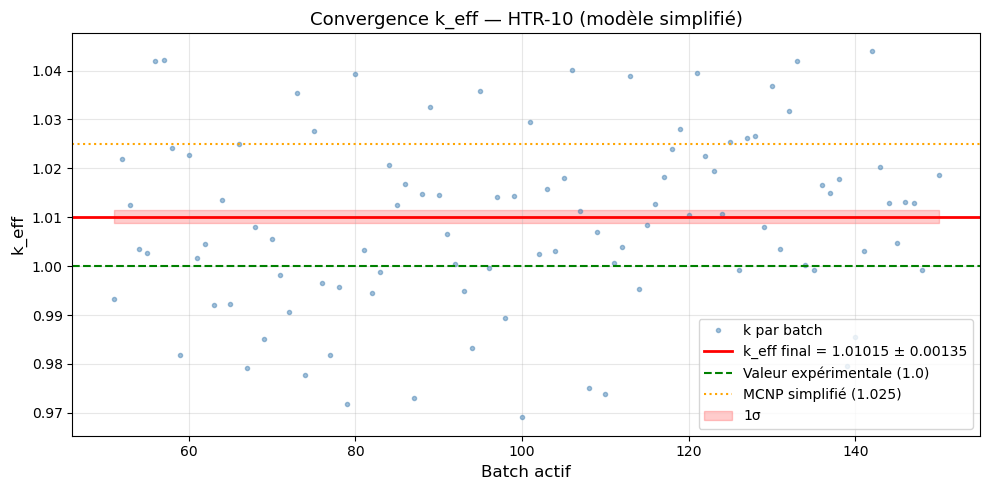

In [23]:
# =============================================================
#  TRACÉ DE LA CONVERGENCE k_eff
# =============================================================

import matplotlib.pyplot as plt

if os.path.exists('statepoint.150.h5'):
    sp = openmc.StatePoint('statepoint.150.h5')

    # Batches actifs
    k_batches = sp.k_generation[inactive:]  # valeurs par batch
    k_combined = sp.k_combined              # k_eff accumulé

    fig, ax = plt.subplots(figsize=(10, 5))
    batch_numbers = np.arange(inactive + 1, batches + 1)
    ax.plot(batch_numbers, k_batches, 'o', markersize=3, alpha=0.5,
            color='steelblue', label='k par batch')
    ax.axhline(keff_val, color='red', lw=2,
               label=f'k_eff final = {keff_val:.5f} ± {keff_unc:.5f}')
    ax.axhline(1.0, color='green', lw=1.5, ls='--', label='Valeur expérimentale (1.0)')
    ax.axhline(1.025, color='orange', lw=1.5, ls=':', label='MCNP simplifié (1.025)')
    ax.fill_between(batch_numbers,
                    keff_val - keff_unc, keff_val + keff_unc,
                    color='red', alpha=0.2, label='1σ')
    ax.set_xlabel('Batch actif', fontsize=12)
    ax.set_ylabel('k_eff', fontsize=12)
    ax.set_title('Convergence k_eff — HTR-10 (modèle simplifié)', fontsize=13)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('HTR10_keff_convergence.png', dpi=150)
    plt.show()
else:
    print('Simulation non encore exécutée.')

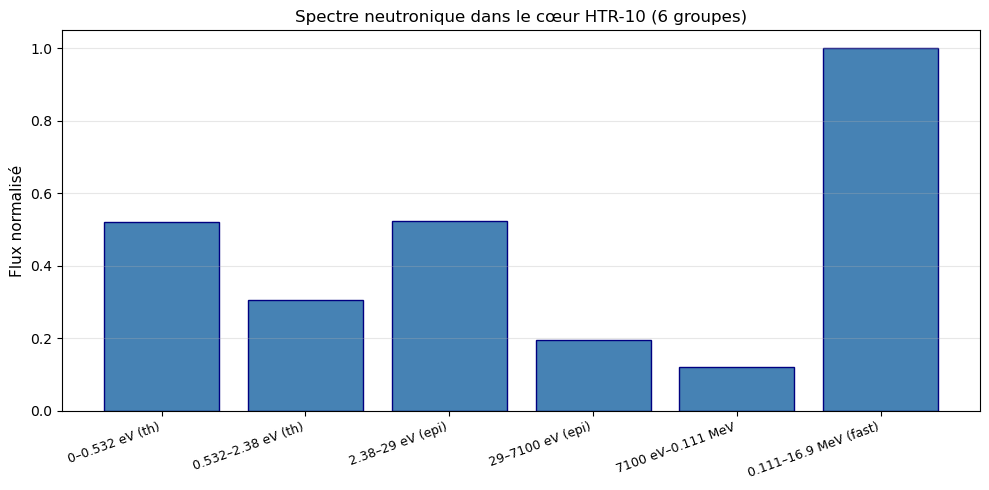

In [24]:
# =============================================================
#  LECTURE DU TALLY FLUX PAR GROUPE
# =============================================================

group_labels = [
    '0–0.532 eV (th)', '0.532–2.38 eV (th)',
    '2.38–29 eV (epi)', '29–7100 eV (epi)',
    '7100 eV–0.111 MeV', '0.111–16.9 MeV (fast)'
]

if os.path.exists('statepoint.150.h5'):
    sp = openmc.StatePoint('statepoint.150.h5')
    t_flux = sp.get_tally(name='flux_core_6groups')
    flux_vals = t_flux.get_values(scores=['flux']).flatten()
    # OpenMC retourne du bas vers le haut en énergie
    flux_vals = flux_vals[::-1]

    fig, ax = plt.subplots(figsize=(10, 5))
    x = np.arange(len(group_labels))
    ax.bar(x, flux_vals / flux_vals.max(), color='steelblue', edgecolor='navy')
    ax.set_xticks(x)
    ax.set_xticklabels(group_labels, rotation=20, ha='right', fontsize=9)
    ax.set_ylabel('Flux normalisé', fontsize=11)
    ax.set_title('Spectre neutronique dans le cœur HTR-10 (6 groupes)', fontsize=12)
    ax.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('HTR10_spectrum.png', dpi=150)
    plt.show()
else:
    print('Simulation non encore exécutée.')

---
## 7. RÉSUMÉ DES DONNÉES NUCLÉAIRES UTILISÉES

| Paramètre | Valeur | Source |
|-----------|--------|--------|
| Puissance thermique | 10 MWt | Table 1.1 |
| Diamètre cœur | 180 cm | Table 1.3 |
| Hauteur critique | 123.06 cm | Sect. 1.1.2 |
| Nombre de billes total | 16 890 | Sect. 1.1.2 |
| Billes combustible / dummy | 9627 / 7263 (57:43) | Sect. 1.1.2 |
| Fraction volumique billes | 0.61 | Table 1.2 |
| Enrichissement 235U | 17 % massique | Table 1.4 |
| Charge U par bille | 5.0 g | Table 1.4 |
| Rayon du noyau UO₂ | 0.025 cm | Table 3.1 |
| Épaisseurs TRISO | Buffer:0.09 / IPyC:0.04 / SiC:0.035 / OPyC:0.04 mm | Table 1.2 |
| Densité graphite combustible | 1.73 g/cm³ | Table 1.4 |
| Densité graphite dummy | 1.84 g/cm³ | Table 1.4 |
| Densité graphite réflecteur | 1.76 g/cm³ | Table 3.4 |
| Bore réflecteur (naturel) | 4.8366 ppm | Table 3.4 |
| Coolant | Air saturé 15°C, 0.1013 MPa | Sect. 1.1.3 |
| k_eff expérimental | 1.000 | Sect. 3.1.5 |
| k_eff MCNP simplifié | 1.025 ± 0.00021 | Table 4.1 |
| Incertitude totale | 0.00624 (1σ) | Table 2.1 |